In [1]:
# import test_tensor_2d as tt ttbd
import quimb as qu
import quimb.tensor as qtn
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import itertools
import dense_qubits as dq
import exact_jwt
import stabilizers as stab
import qubit_networks as beeky ###
from itertools import product
import autoray
import scipy.sparse as sparse
import functools
import assorted_conts as ac
from quimb.utils import pairwise

In [2]:
%matplotlib inline

In [264]:
reload(beeky)
T_, V_, MU_ = 1.0, 1.0, 2.0
qlat = dq.SpinlessHub(Lx=2, Ly=3)
mpoham = beeky.MPOSpinlessHam(qlat, T_, V_, MU_)
simham = beeky.SpinlessSimHam(qlat, T_, V_, MU_)

qnet = beeky.QubitEncodeVector.rand(qlat)
# mpo146 = mpoham._ham_terms[(1,4,6)]

# t0=qnet.apply_mpo(mpo=mpo146, where=(0,3,6), contract=True)


In [5]:
reload(dq)

##Testing params
T_PARAM=1
V_PARAM=2
MU_PARAM=0
LX, LY = 2, 3


### Analytical Hubbard Hamiltonian
hub = exactJWT.HubbardSpinless(Lx=LX, Ly=LY)
hub.build_spinless_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
Hexact = hub._Ham.copy()
gex, gsx = qu.eigh(Hexact)
print(f'Exact: {gex[0:3]}')

# nx = hub.state_occs(state=gsx[:,0])
# print(nx,end='\n\n')


### Qubit lattice Hamiltonian
sql = dq.SpinlessHub(Lx=LX,Ly=LY)
sql.make_simulator_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
simHam = sql.ham_sim()
sens, seigst = qu.eigh(simHam)
print(f'Nonstable: {sens[0:3]}')

sql.make_stabilizer()
codeHam = sql.ham_code()
rens, reigst = qu.eigh(codeHam)
print(f'Stable: {rens[0:3]}')

# print(sql.state_local_occs(k=None, qstate=Uplus@reigst[:,0]))

Exact: [-3.06118188 -2.41421356 -2.27945232]
Nonstable: [-3.18711224 -3.06118188 -2.41421356]
Stable: [-3.06118188 -2.41421356 -2.27945232]


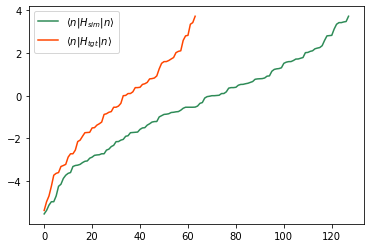

In [148]:
plt.plot(sens, label=r'$\langle n|H_{sim}|n\rangle$', color='seagreen')
plt.plot(rens, label=r'$\langle n|H_{tgt}|n\rangle$', color='orangered')
plt.legend()

***
**Imaginary time evolution**
***

Examine how changing the time-evolution Hamiltonian from the qubit Hamiltonian $H_{sim}$ to the "effective error-correcting" Hamiltonian $H_{master} = H_{sim} + H_{stab}$ changes the results.

* $H_{sim}$ has non-fermionic eigenstates, so imaginary-time evolution takes us out of the stable subspace and gives a "fake" non-fermionic ground state.

* $H_{master}$ includes a term to "incentivize" overlap with the stable subspace, which the imaginary-time evolution in the direction of the stable (fermionic) part of the Hilbert space.


In [17]:
reload(beeky)
reload(dq)

T_PARAM=1.0
V_PARAM=1.26
MU_PARAM=0.9

qlat = dq.SpinlessHub(Lx=2,Ly=3)
qlat.make_simulator_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
simHam = qlat.ham_sim()
sens, seigst = qu.eigh(simHam)
print(f'Nonstable: {sens[0:3]}')

qlat.make_stabilizer()
codeHam = qlat.ham_code()
rens, reigst = qu.eigh(codeHam)
print(f'Stable: {rens[0:3]}')

HSIM = beeky.SpinlessSimHam(Lx=2, Ly=3, t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
HSTAB = beeky.HamStab(Lx=2, Ly=3)
HMASTER = beeky.MasterHam(HSIM, HSTAB)

tensors = beeky.make_random_net(Lx=2, Ly=3, phys_dim=2)
net1 = beeky.QubitEncodeVector(tensors.copy(), Lx=2, Ly=3,)
net2 = beeky.QubitEncodeVector(tensors.copy(), Lx=2, Ly=3,)
net3 = beeky.QubitEncodeVector(tensors.copy(), Lx=2, Ly=3,)

psi0 = net1.vec_to_dense()
print('<H(0)>:  ',net1.compute_ham_expec(HSIM, normalize=True))


Nonstable: [-5.53274124 -5.37051838 -5.12289199]
Stable: [-5.37051838 -4.9630457  -4.69530491]
<H(0)>:   (-0.4872534417287318+1.7614723425303386e-17j)


In [18]:
reload(beeky)

comp_fns = {'stab' : functools.partial(beeky.compute_encnet_ham_expec, ham = HSTAB),
            'norm':beeky.compute_encnet_normsquared,
            'sim': functools.partial(beeky.compute_encnet_ham_expec, ham=HSIM)  }

#MASTER evolve (fermionic)
tebd1 = beeky.iTimeTEBD(net1, ham=HMASTER, compute_every=50,compute_extra_fns=comp_fns)

#SIM evolve (non fermionic)
tebd2 = beeky.iTimeTEBD(net2, ham=HSIM, compute_every=50,compute_extra_fns=comp_fns)

#STAB then SIM (should be equiv to MASTER)
tebd3a = beeky.iTimeTEBD(net3, ham=HSTAB, compute_every=50, compute_extra_fns=comp_fns)
tebd3b = beeky.iTimeTEBD(net3, ham=HSIM, compute_every=50, compute_extra_fns=comp_fns)

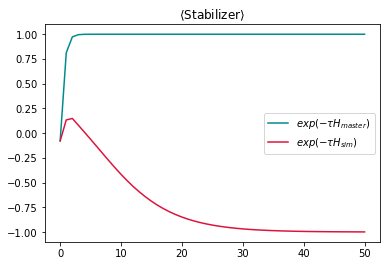

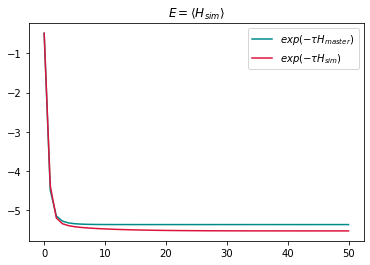

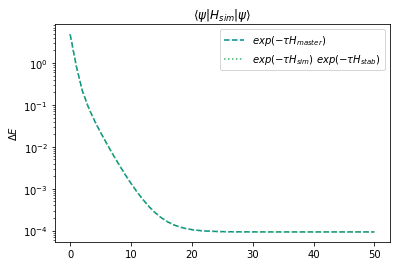

In [22]:
# tebd1.evolve(2500)
# tebd2.evolve(2500)
# tebd3a.evolve(1000)
# tebd3b.evolve(2500)


masterstring = r'$exp(-\tau H_{master})$'
# masterstring = r'$U_{master}(\tau)$'
# simstring = r'$U_{sim}(\tau)$'
simstring = r'$exp(-\tau H_{sim})$'
stabstring = r' $exp(-\tau H_{stab})$'

# seqstring = r'$U_{sim}(\tau)$ $U_{stab}(T)$'

strs = {'master' : masterstring,
          'sim' : simstring,
          'seq' : simstring+stabstring
          }
colormap = {'master':'darkcyan',
            'sim' : 'crimson',
            'seq' : 'mediumseagreen'}          

# taus1 = tebd1.tau*np.array(tebd1.iters)
# taus2 = tebd2.tau*np.array(tebd1.iters)

plt.plot(-tebd1.get_final_data('Estab'),label=strs['master'], color=colormap['master'])
plt.plot(-tebd2.get_final_data('Estab'), label=strs['sim'], color=colormap['sim'])
# plt.plot(-tebd3a.get_final_data('Estab'),label=strs['seq'], color=colormap['seq'])
plt.title(r'$\langle$Stabilizer$\rangle$')
plt.legend()
plt.show()


plt.plot(tebd1.get_final_data('Esim'),label=strs['master'], color=colormap['master'])
plt.plot(tebd2.get_final_data('Esim'), label=strs['sim'], color=colormap['sim'])
# plt.plot(tebd3b.get_final_data('Esim'), label=strs['seq'], color=colormap['seq'])
plt.title(r'$E=\langle H_{sim}\rangle$')
plt.legend()
plt.show()



plt.semilogy((tebd1.get_final_data('Esim'))-rens[0],ls='dashed',label=strs['master'], color=colormap['master'])
plt.semilogy(tebd3b.get_final_data('Esim')-rens[0],ls='dotted', label=strs['seq'], color=colormap['seq'])
plt.ylabel(r'$\Delta E$')
# plt.hlines(y=rens[0], xmin=0, xmax=taus[-1], ls='dashed', colors='k')
plt.title(r'$\langle\psi|H_{sim}|\psi\rangle$')
plt.legend()
plt.show()




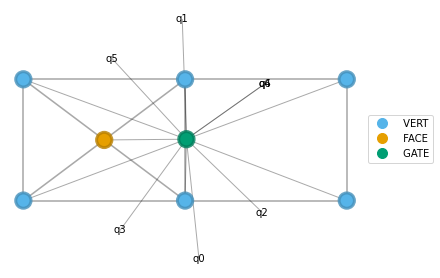

In [25]:
net3.graph()

In [36]:
reload(stab)
reload(dq)

qlat = dq.SpinlessDense(Lx=2,Ly=3)
# code_dims = [2]*6
# sim_dims = [2]*7
U, Udag = stab.one_qubit_U_matrices(qlat, (0,1))
qlat.loop_stabilizer_data(0,1)

{'inds': (1, 2, 5, 4, 6), 'opstring': 'ZZZZX'}

***
**Local Product States**
***
Use `QubitEncodeVector.rand_local_product_state` to make a "local product state" where the vertex-face squares are internally entangled, but unentangled with the rest of the network. 

Right now the "product" bonds (i.e. zero entanglement bonds) are padded with zeros up to `d=2`, while the entangled bonds take `d=bond_dim`.

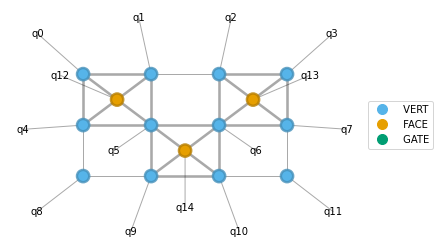

In [3]:
qvec = beeky.QubitEncodeVector.rand_local_product_state(Lx=3, Ly=4, bond_dim=6)
qvec.graph()

Now we want to test the norm contraction $\langle \psi|\psi\rangle$ for local product state (LPS) wavefunctions, which should have weaker entanglement compared to *random* wavefunctions.

In [12]:
reload(beeky)
LX, LY = (3, 4)
D_bond = 3

#medium entanglement
psi_lps = beeky.QubitEncodeVector.rand_local_product_state(Lx=LX, Ly=LY, bond_dim=D_bond)

#high entanglement
psi_rnd = beeky.QubitEncodeVector.rand(Lx=LX, Ly=LY, bond_dim=D_bond)

#make norm and rotate face tensors, since we are going to do BMPS
norm_lps = psi_lps.make_norm().setup_bmps_contraction_(layer_tags=('BRA', 'KET'))
norm_rnd = psi_rnd.make_norm().setup_bmps_contraction_(layer_tags=('BRA', 'KET'))

results = {'exact_lps': norm_lps^all, 'exact_rnd': norm_rnd^all, 'approx_lps':[], 'approx_rnd':[]}

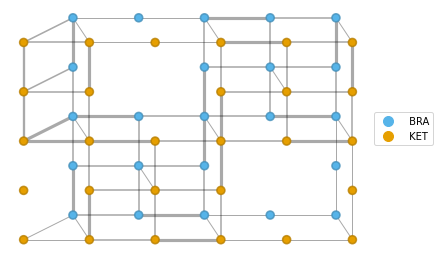

In [13]:
norm_lps.contract_boundary_from_left(xrange=(0,4), yrange=(0,1), layer_tags=('BRA', 'KET'), max_bond=5).graph_layers(color=("BRA", 'KET'))

In [14]:
for chi in range(2, 86, 2):
    nlps = norm_lps.contract_boundary(sequence=['b'], layer_tags=('BRA', 'KET'), max_bond=chi)
    results['approx_lps'].append((chi, nlps))
    nrnd = norm_rnd.contract_boundary(sequence=['b'], layer_tags=('BRA', 'KET'), max_bond=chi)
    results['approx_rnd'].append((chi, nrnd))

Text(0.5, 1.0, 'Initial $D=3$, $L_x, L_y = (3, 4)$')

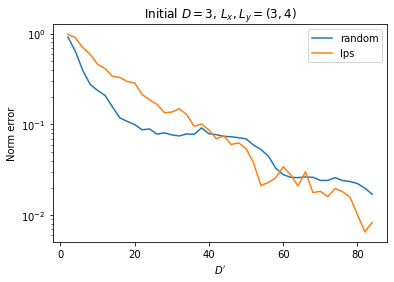

In [16]:
errs = dict({'psi_random': [], 'psi_lps': []})

for (chi, nrnd) in results['approx_rnd']:
    error = abs(1 - nrnd/results['exact_rnd'])
    errs['psi_random'].append((chi, error))
for (chi, nlps) in results['approx_lps']:
    error = abs(1 - nlps/results['exact_lps'])
    errs['psi_lps'].append((chi, error))
plt.semilogy(*zip(*errs['psi_random']), label='random')
plt.semilogy(*zip(*errs['psi_lps']), label='lps')
plt.legend()
plt.ylabel('Norm error')
plt.xlabel("$D'$")
plt.title(f"Initial $D={D_bond}$,  $L_x, L_y = {LX, LY}$")
# plt.title(f'$D={D_bond}$')

Hmm. So not that big a difference.

***
**Applying stabilizers to a qubit state**
***
The stabilizers for a lattice of shape `(Lx, Ly)` are encoded in `HamStab(Lx, Ly).gen_ham_stabilizer_lists()`, which yields pairs like *(integer qubits to act on, ordered 1-qubit gates)*

In [48]:
Lx_, Ly_ = 2, 3
Hstab = beeky.HamStab(Lx=Lx_, Ly=Ly_)

for k, (qubits, gates) in enumerate(Hstab.gen_ham_stabilizer_lists()):
    print(f"Stabilizer {k} acts on qubits ", qubits)

Stabilizer 0 acts on qubits  (1, 2, 5, 4, 6)


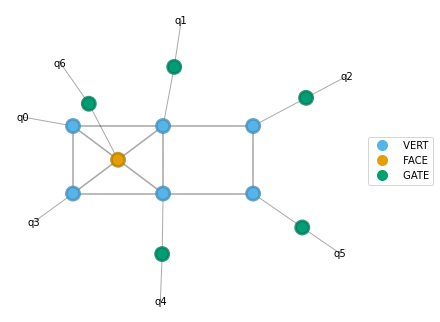

In [49]:
# pick the first stabilizer
S1 = list(Hstab.gen_ham_stabilizer_lists())[0] 

#apply it to a state
psi = beeky.QubitEncodeVector.rand(Lx_, Ly_)
psi.apply_stabilizer(qubits=S1[0], gates=S1[1], inplace=True, contract=False)

psi.graph()

We can see that the first stabilizer is centered in the upper-right "face" site, and acts on 4 corners + 2 adjacent faces.

In [51]:
reload(beeky)
expectations1 = [] #
expectations2 = [] #

psi = beeky.QubitEncodeVector.rand(Lx_, Ly_)
norm = psi.make_norm()^all

for S in Hstab.gen_ham_stabilizer_lists():
    expectations1.append(psi.compute_stabilizer_expec(
        qubits = S[0], gates = S[1], setup_bmps=True, norm=norm))

psi.setup_bmps_contraction_()#.normalize_()
new_norm = psi.make_norm()^all

bra = psi.copy().H
bra.add_tag('BRA')

boundary_contract_opts = {'layer_tags': ('KET', 'BRA')}

for S in Hstab.gen_ham_stabilizer_lists():
    
    S_ket = psi.apply_stabilizer(qubits=S[0], gates=S[1], inplace=False)
    S_ket.add_tag('KET')

    expectations2.append((bra | S_ket).contract_boundary(**boundary_contract_opts) / new_norm)

print(np.allclose(np.real(expectations1), np.real(expectations2)))

True


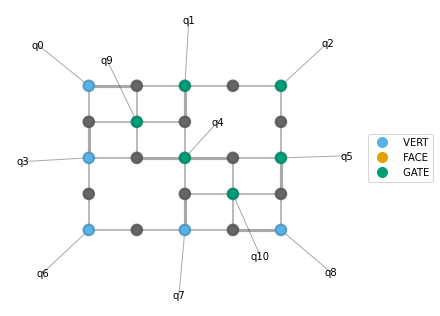

In [47]:
S = next(Hstab.gen_ham_stabilizer_lists())
S_ket = psi.apply_stabilizer(qubits=S[0], gates=S[1])
S_ket.graph()

***
For lattice size $>2\times 3$, we get stabilizer expectation $\langle\psi|S|\psi\rangle=$  flat 0, so let's try this with a ground state (not random). Try TEBD?

In [113]:
reload(beeky)
# Hubbard parameters
T_PARAM=1.0
V_PARAM=1.2
MU_PARAM=0

LX, LY = (2, 3) #lattice size 

# Encoded Hamiltonian 
HSIM = beeky.SpinlessSimHam(Lx=LX, Ly=LY, t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
# Stabilizers 
HSTAB = beeky.HamStab(Lx=LX, Ly=3)
# Hsim + Hstab
HMASTER = beeky.MasterHam(HSIM, HSTAB)

# Make 3 copies of the same (random) initial state
net1 = beeky.QubitEncodeVector.rand(Lx=LX, Ly=LY, bond_dim=3)
net2 = net1.copy()
net3 = net1.copy()

comp_fns = {'stab' : functools.partial(beeky.compute_encnet_ham_expec, ham = HSTAB),
            'norm':beeky.compute_encnet_normsquared,
            'sim': functools.partial(beeky.compute_encnet_ham_expec, ham=HSIM)}


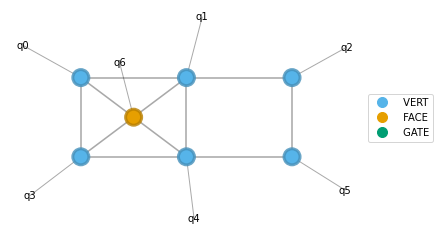

In [108]:
net1.graph()

In [116]:

#Stabilizer evolve (no energy, just seek fermionic codespace)
# tebd1 = beeky.iTimeTEBD(net1, ham=HSTAB, compute_every=50,compute_extra_fns=comp_fns)
# tebd1.evolve(1000)

net1.setup_bmps_contraction_()
norm= net1.make_norm() ^ all

E_Hstab = net1.compute_ham_expec(HSTAB)

Expec_stab = 0
for S in HSTAB.gen_ham_stabilizer_lists():
    Expec_stab += net1.compute_stabilizer_expec(qubits = S[0], gates = S[1], setup_bmps=False, norm=norm)
    
# print(tebd1.get_normalized_data('Estab'))
# plt.plot(tebd1.get_normalized_data('Estab'))

'setup_bmps' exited, face qubits already rotated!


In [115]:
print(Expec_stab, E_Hstab)

(0.06906171006471819+2.0870248823879364e-16j) (0.06906171006471803+5.3214984278221435e-18j)


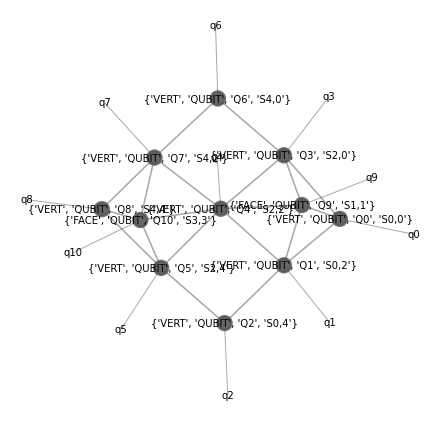

In [83]:
reload(beeky)
beeky.make_product_state_net(Lx=3, Ly=3, phys_dim=2, bitstring='00100100100').graph()

In [72]:
all(c in '01' for c in '0101010000a')

0
1
0
1
